# scRNA-seq Analysis Pipeline

This pipeline enables you to analyze and visualize your single cell RNA sequencing datasets with an array of algorithms and data visualization methods. The pipeline includes quality control, library size analysis, normalization, plotting most highly expressed genes, plotting samples, MAGIC normalization, clustering, enrichment analysis, trajectory inference, and cell type prediction.

In [59]:
#%%appyter init
from appyter import magic
magic.init(lambda _=globals: _())

In [60]:
# Basic libraries
import pandas as pd
import random
import time
import numpy as np
import warnings

# Visualization
import seaborn as sns
import scipy.stats as ss
import plotly
from plotly import tools
import plotly.express as px
import plotly.graph_objs as go
import matplotlib.pyplot as plt; plt.rcdefaults()
from matplotlib import rcParams
from matplotlib.lines import Line2D
from matplotlib_venn import venn2, venn3
import IPython
from IPython.display import HTML, display, Markdown, IFrame, FileLink, Image
from itertools import combinations
from scipy import stats
import chart_studio
import chart_studio.plotly as py
from PIL import Image

# Data analysis
from sklearn.decomposition import PCA
from sklearn.preprocessing import quantile_transform
from sklearn import cluster
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
import umap
from rpy2 import robjects
from rpy2.robjects import r, pandas2ri
from magic import MAGIC
import scanpy as sc
import anndata
import DigitalCellSorter


# External Code
from utils import *
from plotly.offline import init_notebook_mode
init_notebook_mode(connected = True)

In [61]:
%%appyter hide_code_exec
{% do SectionField(
    name='Data_Section',
    title='Load your Data',
    subtitle='Load your expression data. In comma/tab separated formats, genes should be in rows and samples shoud be in columns. You can also upload Cell Ranger files (matrix, genes, and barcords files). ',
    img='analysis.png'
    
) %}

{% do SectionField(
    name='Normalization_Section',
    title='Select Normalization Methods',
    subtitle='',
    img='analysis.png'
    
) %}

{% do SectionField(
    name='Visualization_Section',
    title='Select Visualization Parameters',
    subtitle='',
    img='analysis.png'
    
) %}

{% do SectionField(
    name='DEG_Section',
    title='Select Differentially Exprssed Gene Analysis Parameters',
    subtitle='',
    img='analysis.png'
    
) %}

{% do SectionField(
    name='TI_Section',
    title='Select Trajectory Inference Parameters',
    subtitle='',
    img='analysis.png'
    
) %}

{% do SectionField(
    name='Time_TI_Section',
    title='Select Time-series Trajectory Inference Parameters',
    subtitle='',
    img='analysis.png'
    
) %}

{% do SectionField(
    name='CT_Section',
    title='Select Cell Type Prediction Parameters',
    subtitle='',
    img='analysis.png'
    
) %}

In [62]:
%%appyter code_exec

{% set file_kind = TabField(
    name='file_kind',
    label='Data file',
    default='Plain text',
    description='Upload your expression files',
    choices={
        'Plain text': [             
            FileField(
                name='rnaseq_data_filename', 
                label='RNA-seq data file (.csv, .txt or .tsv)', 
                default='GSE110499_example_expression.txt',
                examples={'GSE110499_example_expression.txt': 'https://appyters.maayanlab.cloud/storage/SC_RNA_seq/GSE110499-expression.txt'}, 
                description='Upload RNA-seq expression data as comma seperated or tab seperated format. The index of the dataset are genes, the columns are samples.', 
                section='Data_Section'
            ),
            FileField(
                name='meta_data_filename', 
                label='(Optional) Meta data file (.csv, .txt or .tsv)', 
                default='GSE110499_example_metadata.txt',
                examples={'GSE110499_example_metadata.txt': 'https://appyters.maayanlab.cloud/storage/SC_RNA_seq/GSE110499-metadata.txt'}, 
                description='Upload metadata as two-column comma seperated or tab seperated format. The first column contains sample IDs and the other column contains sample labels',
                section='Data_Section'
            ),         
            StringField(
                name='meta_class_column_name', 
                label='(Optional) Class column name in metadata', 
                default='prep-site', 
                description='class column name of metadata', 
                section='Data_Section'
            )


        ],
        
        '.mtx from 10x Genomics': [
            FileField(
                name='mtx_data_filename', 
                label='RNA-seq data file (.mtx)', 
                default='example_matrix.mtx',
                examples={'example_matrix.mtx': 'https://appyters.maayanlab.cloud/storage/SC_RNA_seq/example_matrix.mtx'}, 
                description='Expression data file from 10x Genomics need to be in .mtx format which store the expression data in sparse matrix.',
                section='Data_Section'
            ),
            FileField(
                name='gene_data_filename', 
                label='Gene infomation file (.tsv)', 
                default='example_genes.tsv',
                examples={'example_genes.tsv': 'https://appyters.maayanlab.cloud/storage/SC_RNA_seq/example_genes.tsv'}, 
                description='A tab delimited file of the corresponding genes in the .mtx expression matrix file. The first column should be the gene IDs whereas the secound column corresponds to gene symbols.', 
                section='Data_Section'
            ),
            FileField(
                name='barcode_data_filename', 
                label='Barcode information file (.tsv)', 
                default='example_barcodes.tsv',
                examples={'example_barcodes.tsv': 'https://appyters.maayanlab.cloud/storage/SC_RNA_seq/example_barcodes.tsv'}, 
                description='A tab delimited file of the corresponding barcodes in the .mtx expression matrix file. The first column should be the unique barcodes for cells.', 
                section='Data_Section'
            ),
            FileField(
                name='meta_data_filename_mtx', 
                label='(Optional) Meta data file (.csv, .txt or .tsv)', 
                default='',
                examples={'example_metadata.tsv': 'https://appyters.maayanlab.cloud/storage/SC_RNA_seq/example_metadata.tsv'}, 
                description='Upload metadata as two-column comma seperated or tab seperated format. The first column contains sample IDs and the other column contains sample labels',
                section='Data_Section'
            ),         
            StringField(
                name='meta_class_column_name_mtx', 
                label='(Optional) Class column name in metadata', 
                default='', 
                description='class column name of metadata', 
                section='Data_Section'
            )
        ]
        
    },
    section = 'Data_Section',
) %}



In [63]:
%%appyter code_exec
{% set qc_filter_genes = BoolField(
    name='qc_filter_genes', 
    label='Filter genes by quality control?', 
    default='true', 
    description='Check if you want cells to be filtered by quality control', 
    section='Normalization_Section')
%}

{% set qc_threshold = FloatField(
    name='qc_threshold', 
    label='Mitochondria Quality Control threshold', 
    default='0.05', 
    description='Remove cells that have too many mitochondrial genes expressed.', 
    section='Normalization_Section')
%} 

{% set log_normalization = BoolField(
    name='log_normalization', 
    label='Log normalization?', 
    default='true', 
    description='Check if you want the dataset to be log-transformed', 
    section='Normalization_Section')
%}
{% set normalization_method = ChoiceField(
    name='normalization_method',
    label='Normalization',
    choices={'None': 'None', 'Satija et al. (2015, Nature Biotechnology)': 'Seurat', 'Zheng et al. (2017, Nature Communications)': 'Zheng17','Weinreb et al. (2018, PNAS)': 'Weignreb17'},
    default='Satija et al. (2015, Nature Biotechnology)', 
    description='Standard normlization recipe for scRNA-seq datasets', 
    section='Normalization_Section')
%}
{% set magic = BoolField(
    name='magic', 
    label='MAGIC?', 
    default='true', 
    description='Check if you want impute missing data with Markov Affinity-based Graph Imputation of Cells (MAGIC)', 
    section='Normalization_Section')
%}

In [64]:
%%appyter code_exec
{% set interactive_plot = BoolField(
    name='interactive_plot', 
    label='Interactive plots?', 
    default='true', 
    description='Check if you want interactive plots', 
    section='Visualization_Section')
%}
{% set highest_expr_n_genes = IntField(
    name='highest_expr_n_genes', 
    label='Genes for highest expression', 
    min=0, 
    max=100, 
    default=10, 
    description='The number of genes with highest expression values', 
    section='Visualization_Section')
%}
{% set dim_reduction_method = ChoiceField(
    name='dim_reduction_method',
    label='Method for dimension reduction',
    choices={'PCA': 'PCA','t-SNE': 't-SNE', 'UMAP': 'UMAP'},
    default='PCA', 
    description='Dimension reduction methods', 
    section='Visualization_Section')
%}
{% set nr_genes = IntField(
    name='nr_genes', 
    label='Genes for dimension reduction', 
    min=0, 
    max=30000, 
    default=500, 
    description='The maximum number of genes for dimension reduction analysis', 
    section='Visualization_Section')
%}
gene_list_for_clustergrammer = {{TextField(
    name='gene_list_for_clustergrammer', 
    label='Gene List for Clustergrammer (Optional)', 
    default='', 
    description='Paste your gene list (One gene per row) for Clustergrammer heatmap plots.', 
    section = 'Visualization_Section')}}
{% set clustering_topk = IntField(
    name='clustering_topk', 
    label='Genes for clustergrammer', 
    min=0, 
    max=1000, 
    default=800, 
    description='The number of genes with largest variance for Clustergrammer', 
    section='Visualization_Section')
%}


```python

gene_list_for_clustergrammer = ''''''
```

In [65]:
%%appyter code_exec

{% set deg = BoolField(
    name='deg',
    label='Differentially expressed gene analysis?',
    default='true',
    description='Check if you want differentially expressed gene analysis', 
    section='DEG_Section')
%}

{% set enrichment_groupby = ChoiceField(
    name='enrichment_groupby',
    label='Group for differentially expressed gene analysis',
    choices={'Cluster': 'Cluster', 'User-defined class': 'user_defined_class'},
    default='User-defined class', 
    description='Specify groups for enrichment analysis. Clusters will be automatically generated by a clustering method', 
    section='DEG_Section')
%}

{% set diff_gex_method = ChoiceField(
    name='diff_gex_method',
    label='Differential expression analysis method',
    choices={'limma': 'limma','characteristic direction': 'characteristic_direction', 'edgeR': 'edgeR', 'DESeq2': 'DESeq2'},
    default='limma', 
    description='Set a method to get differentially expressed genes', 
    section='DEG_Section')
%}



{% set gene_topk = IntField(
    name='gene_topk', 
    label='Maximum genes for Enrichr', 
    min=0, 
    max=1000, 
    default=200, 
    description='The maximum number of genes discovered by the DEG method', 
    section='DEG_Section')
%}


{% set enrichr_libraries = MultiChoiceField(
    name='enrichr_libraries',
    label='Enrichr Libraries (upto 2)',
    descriptions='Enrichr libraries to be visualized. Select one or two libraries',
    choices=['Gene Ontology',
            'Pathway',
            'Kinase',
            'Transcription Factor',
            'miRNA',
            'Cell Type'],
    default=['Gene Ontology',
            'Cell Type'],
    section='DEG_Section'
    )
%}

{% set nr_genesets = IntField(
    name='nr_genesets', 
    label='Top ranked gene sets', 
    min=0, 
    max=100,
    default=15, 
    description='the number of result gene sets', 
    section='DEG_Section')
%}


In [66]:
%%appyter code_exec
{% set trajectory = BoolField(
    name='trajectory',
    label='Trajectory Inference?',
    default='true',
    description='Check if you want trajectory inference analysis', 
    section='TI_Section')
%}

{% set trajectory_method = ChoiceField(
    name='trajectory_method',
    label='Trajectory inference method',
    choices={'DPT(diffusion pseudotime)': 'dpt', 'monocle': 'monocle'},
    default='DPT(diffusion pseudotime)', 
    description='Trajectory inference algorithm', 
    section='TI_Section')
%}


In [67]:
%%appyter code_exec
{% set time_series_trajectory = BoolField(
    name='time_series_trajectory', 
    label='Time series trajectory analysis?', 
    default='false', 
    description='Check if you want time-series trajectory analysis', 
    section='Time_TI_Section')
%}
{% set timepoint_labels_column_name = StringField(
    name='timepoint_labels_column_name', 
    label='Timepoint column name in metadata', 
    default='Timepoints', 
    description='Timepoint column name of metadata', 
    section='Time_TI_Section')
%}
timepoint_labels = {{ TextField(
    name='timepoint_labels', 
    label='Ordered timepoint labels in the timepoint label column', 
    default='', 
    description='Paste your timepoint labels in order (One timepoint per row). e.g., 0H, 12H, 24H', 
    section = 'Time_TI_Section') }}


```python

timepoint_labels = ''''''
```

In [68]:
%%appyter code_exec
{% set cell_type_prediction = BoolField(
    name='cell_type_prediction', 
    label='Cell type prediction?', 
    default='false', 
    description='Check if you want cell type prediction', 
    section='CT_Section')
%}

In [69]:
%%appyter code_exec

{%- if file_kind.raw_value == 'Plain text' %}
rnaseq_data_filename = {{ file_kind.value[0] }}
meta_data_filename = {{ file_kind.value[1] }}
meta_class_column_name = {{ file_kind.value[2] }}

{%- elif file_kind.raw_value == '.mtx from 10x Genomics' %}
mtx_data_filename = {{ file_kind.value[0] }}
gene_data_filename = {{ file_kind.value[1] }}
barcode_data_filename = {{ file_kind.value[2] }}
meta_data_filename = {{ file_kind.value[3] }}
meta_class_column_name = {{ file_kind.value[4] }}

{%- elif file_kind.raw_value == '.h5 from 10x Genomics' %}
h5_data_filename = {{ file_kind.value[0] }}
key = {{ file_kind.value[1] }}
{%- endif %}

```python
rnaseq_data_filename = 'GSE110499_example_expression.txt'
meta_data_filename = 'GSE110499_example_metadata.txt'
meta_class_column_name = 'prep-site'
```

In [70]:
%%appyter code_exec

qc_filter_genes = {{qc_filter_genes.value}}
qc_threshold = {{qc_threshold.value}}
log_normalization = {{log_normalization.value}}
normalization_method = "{{normalization_method.value}}"
magic = {{magic.value}}

interactive_plot = {{interactive_plot.value}}
highest_expr_n_genes = {{highest_expr_n_genes.value}}
dim_reduction_method = "{{dim_reduction_method.value}}"
nr_genes = {{nr_genes.value}}
clustering_topk = {{clustering_topk.value}}

deg = {{deg.value}}
enrichment_groupby = "{{enrichment_groupby.value}}"
diff_gex_method = "{{diff_gex_method.value}}"
gene_topk = {{gene_topk.value}}
enrichr_libraries = {{enrichr_libraries.value}}
nr_genesets = {{nr_genesets.value}}

trajectory = {{trajectory.value}}
trajectory_method = "{{trajectory_method.value}}"

time_series_trajectory = {{time_series_trajectory.value}}
timepoint_labels_column_name = "{{timepoint_labels_column_name.value}}"

cell_type_prediction = {{cell_type_prediction.value}}

```python
qc_filter_genes = True
qc_threshold = 0.05
log_normalization = True
normalization_method = "Seurat"
magic = True
interactive_plot = True
highest_expr_n_genes = 10
dim_reduction_method = "PCA"
nr_genes = 500
clustering_topk = 800
deg = True
enrichment_groupby = "Cluster"
diff_gex_method = "limma"
gene_topk = 200
enrichr_libraries = ['Gene Ontology', 'Cell Type']
nr_genesets = 15
trajectory = True
trajectory_method = "dpt"
time_series_trajectory = False
timepoint_labels_column_name = "Timepoints"
cell_type_prediction = False
```

In [71]:
warnings.filterwarnings('ignore')
random.seed(0)
chart_studio.tools.set_credentials_file(username='mjjeon', api_key='v0rpMa6lhST28Sq7XqtM')
pandas2ri.activate()
if interactive_plot == True:
    plot_type='interactive'
else:
    plot_type='static'
results = {}
table_counter = 1
figure_counter = 1
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80)
sc.settings.figdir="./"

# Load datasets

In [72]:
def load_metadata(adata, meta_data_filename, meta_class_column_name):
    if meta_data_filename != "":
        if meta_data_filename.endswith(".csv"):
            meta_df = pd.read_csv(meta_data_filename, index_col=0)
        else:
            meta_df = pd.read_csv(meta_data_filename, sep="\t", index_col=0)
        if meta_class_column_name == "":
            raise Exception ("Run time error: Please provide a proper column name for sample classes in metadata")
        try:
            check_df(meta_df, meta_class_column_name)
        except:
            raise Exception (f"Error! Column '{meta_class_column_name}' is not in metadata")
        adata.obs[meta_class_column_name] = meta_df.loc[:, meta_class_column_name]
        adata.var_names_make_unique()

    else:
        meta_class_column_name = "Class"
        adata.obs[meta_class_column_name] = ["Class0"]*adata.n_obs
        adata.var_names_make_unique()
    
    return adata, meta_class_column_name

In [73]:
%%appyter code_exec

{%- if file_kind.raw_value == 'Plain text' %}
check_files(rnaseq_data_filename)
    
try:
    if rnaseq_data_filename.endswith(".csv"):
        expr_df = pd.read_csv(rnaseq_data_filename, index_col=0).sort_index()
    else:
        expr_df = pd.read_csv(rnaseq_data_filename, index_col=0, sep="\t").sort_index()
    
    # convert df into anndata
    # adata matrix: sample x gene
    adata = anndata.AnnData(expr_df.T)
    adata.X = adata.X.astype('float64')    
    
except:
    print("Error! Input files are in a wrong format. \
    Please check if the index of the expression data are genes and the columns are sample IDs. \
    Sample IDs in the expression data and the metadata should be matched")

del expr_df

{%- elif file_kind.raw_value == '.mtx from 10x Genomics' %}
adata = load_seurat_files(mtx_data_filename, gene_data_filename, barcode_data_filename)

{%- endif -%}
# load meta data
adata, meta_class_column_name = load_metadata(adata, meta_data_filename, meta_class_column_name)    

```python
check_files(rnaseq_data_filename)
try:
    if rnaseq_data_filename.endswith(".csv"):
        expr_df = pd.read_csv(rnaseq_data_filename, index_col=0).sort_index()
    else:
        expr_df = pd.read_csv(rnaseq_data_filename, index_col=0, sep="\t").sort_index()
    # convert df into anndata
    # adata matrix: sample x gene
    adata = anndata.AnnData(expr_df.T)
    adata.X = adata.X.astype('float64')
except:
    print("Error! Input files are in a wrong format. \
    Please check if the index of the expression data are genes and the columns are sample IDs. \
    Sample IDs in the expression data and the metadata should be matched")
del expr_df# load meta data
adata, meta_class_column_name = load_metadata(adata, meta_data_filename, meta_class_column_name)
```

In [74]:
table_counter = display_object(table_counter, "Raw data. The table displays the first 5 rows of the quantified RNA-seq expression dataset. Rows represent genes, columns represent samples, and values show the number of mapped reads.", adata.to_df().iloc[:10,:5].T.head(), istable=True)
table_counter = display_object(table_counter, "Metadata. The table displays the metadata associated with the samples in the RNA-seq dataset. Rows represent RNA-seq samples, columns represent metadata categories.", adata.obs.head(), istable=True)
table_counter = display_object(table_counter, "Sample size for each class. The table displays the number of samples in each class.", adata.obs.reset_index().groupby(meta_class_column_name).count(), istable=True)
   

,GSM2994687,GSM2994688,GSM2994689,GSM2994690,GSM2994691,GSM2994693,GSM2994694,GSM2994695,GSM2994696,GSM2994697
gene_symbol,,,,,,,,,,
A1BG,42.0,9.0,2.0,74.0,23.0,3.0,12.0,2.0,1.0,2.0
A1CF,0.0,0.0,0.0,4.0,0.0,1.0,0.0,0.0,1.0,0.0
A2M,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A2ML1,0.0,1.0,13.0,0.0,5.0,0.0,21.0,0.0,1.0,0.0
A2MP1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


*Table 1. Raw data. The table displays the first 5 rows of the quantified RNA-seq expression dataset. Rows represent genes, columns represent samples, and values show the number of mapped reads.*

,prep-site
GSM2994687,Bone marrow
GSM2994688,Bone marrow
GSM2994689,Bone marrow
GSM2994690,Bone marrow
GSM2994691,Bone marrow


*Table 2. Metadata. The table displays the metadata associated with the samples in the RNA-seq dataset. Rows represent RNA-seq samples, columns represent metadata categories.*

,index
prep-site,
Ascites,61
Bone marrow,108


*Table 3. Sample size for each class. The table displays the number of samples in each class.*

In [75]:
%%appyter markdown
{%if qc_filter_genes.value == True %}
# Filter Out Cells with QC
High expression levels of mitochondrial genes could be an indicator of poor quality cells (Islam, Saiful, et al. 2014, Ilicic, Tomislav, et al. 2016). In a situation where the cell membrane is broken, cytoplasmic RNA will be lost, but RNAs enclosed in the mitochondria will be retained. This analysis removes single cells that are likely having the cell membrane broken.
{% endif %}


# Filter Out Cells with QC
High expression levels of mitochondrial genes could be an indicator of poor quality cells (Islam, Saiful, et al. 2014, Ilicic, Tomislav, et al. 2016). In a situation where the cell membrane is broken, cytoplasmic RNA will be lost, but RNAs enclosed in the mitochondria will be retained. This analysis removes single cells that are likely having the cell membrane broken.


```python
if adata.var_names[0].startswith("ENSG") == False:
    mito_genes = adata.var_names.str.startswith('MT-')
else:
    gene_symbol_var_names = adata.var_names
    mito_genes = [True if x in gene_id_map_dict and str(gene_id_map_dict[x]).startswith('MT-') else False for x in gene_symbol_var_names ]
# for each cell compute fraction of counts in mito genes vs. all genes
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)
sc.pl.violin(adata, ['percent_mito'],
         jitter=0.4, multi_panel=True, show=True, save=True)
figure_counter = display_object(figure_counter, "Violin plot of the percentage of mitochondrial gene expression counts in each cell", istable=False)
display_link("violin.pdf", "Download figure")
adata = adata[adata.obs.percent_mito < qc_threshold, :]
```

... storing 'prep-site' as categorical


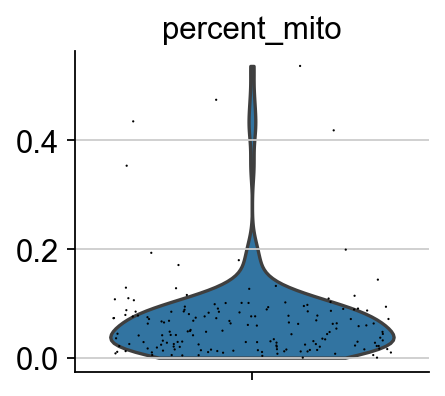

*Figure 1. Violin plot of the percentage of mitochondrial gene expression counts in each cell*

In [76]:
%%appyter code_exec
{%if qc_filter_genes.value == True %}
if adata.var_names[0].startswith("ENSG") == False:
    mito_genes = adata.var_names.str.startswith('MT-')    
else:
    gene_symbol_var_names = adata.var_names
    mito_genes = [True if x in gene_id_map_dict and str(gene_id_map_dict[x]).startswith('MT-') else False for x in gene_symbol_var_names ]

# for each cell compute fraction of counts in mito genes vs. all genes
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)

sc.pl.violin(adata, ['percent_mito'],
         jitter=0.4, multi_panel=True, show=True, save=True)
figure_counter = display_object(figure_counter, "Violin plot of the percentage of mitochondrial gene expression counts in each cell", istable=False)
display_link("violin.pdf", "Download figure")
adata = adata[adata.obs.percent_mito < qc_threshold, :]

{% endif %}

In [77]:
adata.raw = adata

# Library Size Analysis

In order to quantify gene expression in an RNA-seq dataset, reads generated from the sequencing step are mapped to a reference genome and subsequently aggregated into numeric gene counts. Due to experimental variations and random technical noise, samples in an RNA-seq dataset often have variable amounts of the total RNA. Library size analysis calculates and displays the total number of reads mapped for each sample in the RNA-seq dataset, facilitating the identification of outlying samples and the assessment of the overall quality of the data.

In [78]:
adata.obs['n_counts'] = adata.X.sum(axis=1)
library_sum_df = pd.DataFrame(adata.obs['n_counts'])
if len(library_sum_df.index) > 200:
    library_sum_df = library_sum_df.sample(200)
fig = px.bar(library_sum_df.sort_values(by='n_counts'), x=library_sum_df.index, y='n_counts')
if plot_type=='interactive':
    plotly.offline.iplot(fig)
else:
    py.image.ishow(fig)
figure_counter = display_object(figure_counter, "The total number of reads mapped for each sample. The figure contains an interactive bar chart which displays the total number of reads mapped to each RNA-seq sample in the dataset. Additional information for each sample is available by hovering over the bars.", istable=False)


*Figure 2. The total number of reads mapped for each sample. The figure contains an interactive bar chart which displays the total number of reads mapped to each RNA-seq sample in the dataset. Additional information for each sample is available by hovering over the bars.*

In [79]:
%%appyter markdown
{% if normalization_method.value != "None" %}
# Normalization
Various normalization methods can be applied based on the selection made by the user (Zheng, Grace XY, et al. 2017, Weinreb, Caleb, et al. 2018, Butler, Andrew, et al. 2018). These normalization methods convert the raw read counts into standardized measures of gene expression by removing factors that may negatively affect the analysis.
{% endif %}


# Normalization
Various normalization methods can be applied based on the selection made by the user (Zheng, Grace XY, et al. 2017, Weinreb, Caleb, et al. 2018, Butler, Andrew, et al. 2018). These normalization methods convert the raw read counts into standardized measures of gene expression by removing factors that may negatively affect the analysis.


In [80]:
%%appyter code_exec
{% if normalization_method.value != "None" %}
if normalization_method == "Zheng17":
    sc.pp.recipe_zheng17(adata, log=log_normalization, plot=False)
elif normalization_method == "Weinreb17":
    sc.pp.recipe_weinreb17(adata, log=log_normalization)
elif normalization_method == "Seurat":
    sc.pp.recipe_seurat(adata, log=log_normalization, plot=False)
{% endif %}


{% if magic.value == True %}    
adata = run_magic(dataset=adata, dim_reduction_method=dim_reduction_method, meta_class_column_name=meta_class_column_name)
table_counter = display_object(table_counter, "Normalized data. The table displays the expression values after normalization.", adata.uns["magic"].T.head(), istable=True)
display(create_download_link(adata.to_df().T, filename="Normalized_data.csv"))

{% elif normalization_method.value != "None" %}
table_counter = display_object(table_counter, "Normalized data. The table displays the expression values after normalization.", adata.to_df().T.head(), istable=True)
display(create_download_link(adata.to_df().T, filename="Normalized_data.csv"))

{% endif %}

```python
if normalization_method == "Zheng17":
    sc.pp.recipe_zheng17(adata, log=log_normalization, plot=False)
elif normalization_method == "Weinreb17":
    sc.pp.recipe_weinreb17(adata, log=log_normalization)
elif normalization_method == "Seurat":
    sc.pp.recipe_seurat(adata, log=log_normalization, plot=False)
adata = run_magic(dataset=adata, dim_reduction_method=dim_reduction_method, meta_class_column_name=meta_class_column_name)
table_counter = display_object(table_counter, "Normalized data. The table displays the expression values after normalization.", adata.uns["magic"].T.head(), istable=True)
display(create_download_link(adata.to_df().T, filename="Normalized_data.csv"))
```

filtered out 17789 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
Calculating MAGIC...
  Running MAGIC on 85 cells and 411 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculating affinities...
  Calculated graph and diffusion operator in 0.01 seconds.
  Calculating imputation...
    Automatically selected t = 13
  Calculated imputation in 0.40 seconds.
Calculated MAGIC in 0.41 seconds.


,GSM2994687,GSM2994688,GSM2994689,GSM2994690,GSM2994691,GSM2994693,GSM2994694,GSM2994695,GSM2994696,GSM2994697,...,GSM2994808,GSM2994810,GSM2994816,GSM2994820,GSM2994822,GSM2994829,GSM2994832,GSM2994835,GSM2994836,GSM2994860
gene_symbol,,,,,,,,,,,,,,,,,,,,,
AARSD1,-0.079155,-0.079155,-0.079157,-0.079156,-0.079156,-0.079155,-0.079155,-0.079155,-0.079156,-0.079156,...,-0.079152,-0.079153,-0.079154,-0.079154,-0.079152,-0.079154,-0.079154,-0.079154,-0.079153,-0.079156
ABCF2,0.024404,0.024405,0.024400,0.024403,0.024402,0.024404,0.024404,0.024404,0.024400,0.024400,...,0.024412,0.024410,0.024408,0.024408,0.024413,0.024409,0.024409,0.024408,0.024409,0.024403
ABHD17B,-0.051844,-0.051844,-0.051845,-0.051844,-0.051844,-0.051844,-0.051844,-0.051844,-0.051845,-0.051845,...,-0.051843,-0.051843,-0.051843,-0.051843,-0.051842,-0.051843,-0.051843,-0.051843,-0.051843,-0.051844
ACTA2,-0.050664,-0.050663,-0.050664,-0.050664,-0.050664,-0.050663,-0.050663,-0.050663,-0.050664,-0.050664,...,-0.050662,-0.050663,-0.050663,-0.050663,-0.050662,-0.050663,-0.050663,-0.050663,-0.050663,-0.050664
ACTN1,-0.054383,-0.054383,-0.054384,-0.054383,-0.054384,-0.054383,-0.054383,-0.054383,-0.054384,-0.054384,...,-0.054383,-0.054383,-0.054383,-0.054383,-0.054382,-0.054383,-0.054383,-0.054383,-0.054383,-0.054383


*Table 4. Normalized data. The table displays the expression values after normalization.*

# Most Highly Expressed Genes

This analysis displays the genes that yield the highest fraction of counts in each single cell, across all cells.

normalizing counts per cell
    finished (0:00:00)


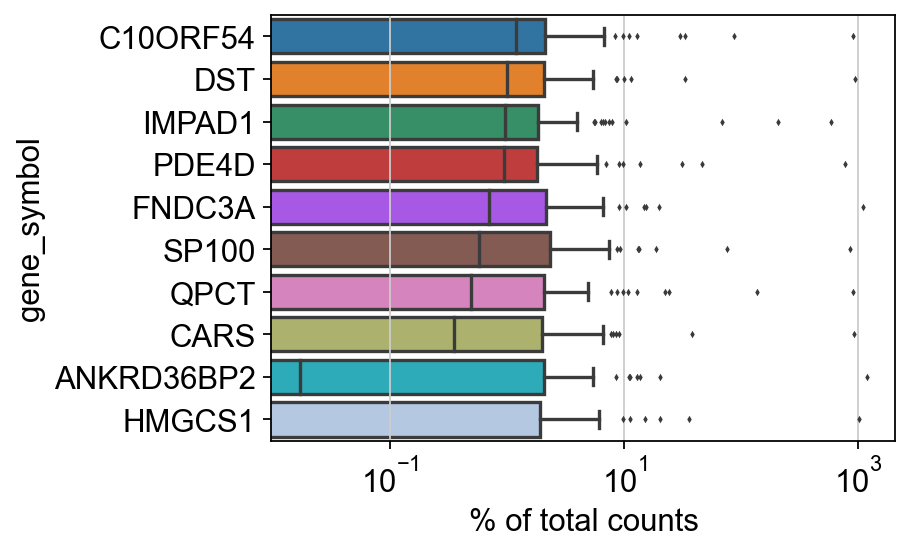

*Figure 3. The 10 genes with the highest mean fraction over all cells sorted by median.*

In [81]:
df = adata.to_df()
df = df.divide(df.sum(axis=1), axis=0)
mean_df = df.mean().sort_values(ascending=False)
yaxis_gene_names = list(mean_df.index)[:highest_expr_n_genes]
median_df = df.median().sort_values(ascending=False)
selected_median_df = median_df.loc[yaxis_gene_names]
sorted_yaxis_gene_names = list(selected_median_df.sort_values(ascending=False).index)
sc.pl.highest_expr_genes(adata, log=True, n_top=highest_expr_n_genes, order=sorted_yaxis_gene_names, show=True, save=True)
figure_counter = display_object(figure_counter, "The {} genes with the highest mean fraction over all cells sorted by median.".format(highest_expr_n_genes), istable=False)
display_link("highest_expr_genes.pdf", "Download figure")    

# Plot the Samples

Principal Component Analysis (PCA ) (Clark, N.R. and Ma’ayan, A., 2011), T-distributed Stochastic Neighbor Embedding (t-SNE) (Maaten, Laurens van der, and Geoffrey Hinton, 2008), Uniform Manifold Approximation and Projection (UMAP) (McInnes, Leland, et al. 2018) are statistical techniques used to identify global patterns in high-dimensional datasets. These techniques are commonly used to explore the similarity of biological samples in RNA-seq datasets. To achieve this, gene expression values are transformed into 2- or 3-dimensional latent vectors and subsequently visualized using a scatter plot.

In [82]:
# Run analysis
results['dimension_reduction'] = run_dimension_reduction(dim_reduction_method, dataset=adata, meta_class_column_name=meta_class_column_name, magic_normalization=False, nr_genes=nr_genes, plot_type=plot_type)
# Display results
plot_dimension_reduction(results['dimension_reduction'])
figure_counter = display_object(figure_counter, '3D {} plot for samples using {} genes having largest variance. \
    The figure displays an interactive, three-dimensional scatter plot of the data. \
    Each point represents an RNA-seq sample. \
    Samples with similar gene expression profiles are closer in the three-dimensional space. \
    If provided, sample groups are indicated using different colors, allowing for easier interpretation of the results.'.format(dim_reduction_method, nr_genes), istable=False)

*Figure 4. 3D PCA plot for samples using 500 genes having largest variance.     The figure displays an interactive, three-dimensional scatter plot of the data.     Each point represents an RNA-seq sample.     Samples with similar gene expression profiles are closer in the three-dimensional space.     If provided, sample groups are indicated using different colors, allowing for easier interpretation of the results.*

In [83]:
%%appyter markdown
{% if magic.value == True %}
# MAGIC
Markov Affinity-based Graph Imputation of Cells (MAGIC) (van Dijk, D., et al. 2017) is an algorithm for denoising high-dimensional data. It is most commonly applied to impute single-cell RNA sequencing data. MAGIC learns the manifold data, using the resultant graph to smooth the features and restore the original structure of the data.
{% endif %}


# MAGIC
Markov Affinity-based Graph Imputation of Cells (MAGIC) (van Dijk, D., et al. 2017) is an algorithm for denoising high-dimensional data. It is most commonly applied to impute single-cell RNA sequencing data. MAGIC learns the manifold data, using the resultant graph to smooth the features and restore the original structure of the data.


In [84]:
%%appyter code_exec
{% if magic.value == True %}
# Run analysis
results['magic_dimension_reduction'] = run_dimension_reduction(dim_reduction_method=dim_reduction_method, dataset=adata, meta_class_column_name=meta_class_column_name, magic_normalization=magic, nr_genes=nr_genes, color_by='auto')
# Display results
plot_dimension_reduction(results['magic_dimension_reduction'])
figure_counter = display_object(figure_counter, "3D {} plot for samples using {} genes having largest variance after MAGIC imputation. The figure displays an interactive, three-dimensional scatter plot of the data. Each point represents an RNA-seq sample. Samples with similar gene expression profiles are closer in the three-dimensional space. If provided, sample groups are indicated using different colors, allowing for easier interpretation of the results.".format(dim_reduction_method, nr_genes), istable=False)
{% endif %}

```python
# Run analysis
results['magic_dimension_reduction'] = run_dimension_reduction(dim_reduction_method=dim_reduction_method, dataset=adata, meta_class_column_name=meta_class_column_name, magic_normalization=magic, nr_genes=nr_genes, color_by='auto')
# Display results
plot_dimension_reduction(results['magic_dimension_reduction'])
figure_counter = display_object(figure_counter, "3D {} plot for samples using {} genes having largest variance after MAGIC imputation. The figure displays an interactive, three-dimensional scatter plot of the data. Each point represents an RNA-seq sample. Samples with similar gene expression profiles are closer in the three-dimensional space. If provided, sample groups are indicated using different colors, allowing for easier interpretation of the results.".format(dim_reduction_method, nr_genes), istable=False)
```

*Figure 5. 3D PCA plot for samples using 500 genes having largest variance after MAGIC imputation. The figure displays an interactive, three-dimensional scatter plot of the data. Each point represents an RNA-seq sample. Samples with similar gene expression profiles are closer in the three-dimensional space. If provided, sample groups are indicated using different colors, allowing for easier interpretation of the results.*

# Clustergrammer

Clustergrammer (Fernandez, Nicolas F., et al. 2017) is a web-based tool for visualizing and analyzing high-dimensional data as interactive and hierarchically clustered heatmaps. It is commonly used to explore the similarity between samples in an RNA-seq dataset. In addition to identifying clusters of samples, it also allows to identify the genes which contribute to the clustering. It visualizes the top 800 genes with largest variance by default or you can upload your gene list.

In [85]:
# Run analysis
results['clustergrammer'] = run_clustergrammer(dataset=adata, meta_class_column_name=meta_class_column_name, gene_list=gene_list_for_clustergrammer)

# Display results
plot_clustergrammar(results['clustergrammer'])
figure_counter = display_object(figure_counter, "Clustered heatmap plot. The figure contains an interactive heatmap displaying gene expression for each sample in the RNA-seq dataset. Every row of the heatmap represents a gene, every column represents a sample, and every cell displays normalized gene expression values. The heatmap additionally features color bars beside each column which represent prior knowledge of each sample, such as the tissue of origin or experimental treatment.".format(highest_expr_n_genes), istable=False)
 

Input data is too large. Random sampling (n=50) is performed.


*Figure 6. Clustered heatmap plot. The figure contains an interactive heatmap displaying gene expression for each sample in the RNA-seq dataset. Every row of the heatmap represents a gene, every column represents a sample, and every cell displays normalized gene expression values. The heatmap additionally features color bars beside each column which represent prior knowledge of each sample, such as the tissue of origin or experimental treatment.*

# Clustering
The Leiden algorithm (Traag, Vincent A., et al. 2019) is a method to identify well-connected clusters in networks. 

computing neighbors
         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50
    finished (0:00:00)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 6 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:00)


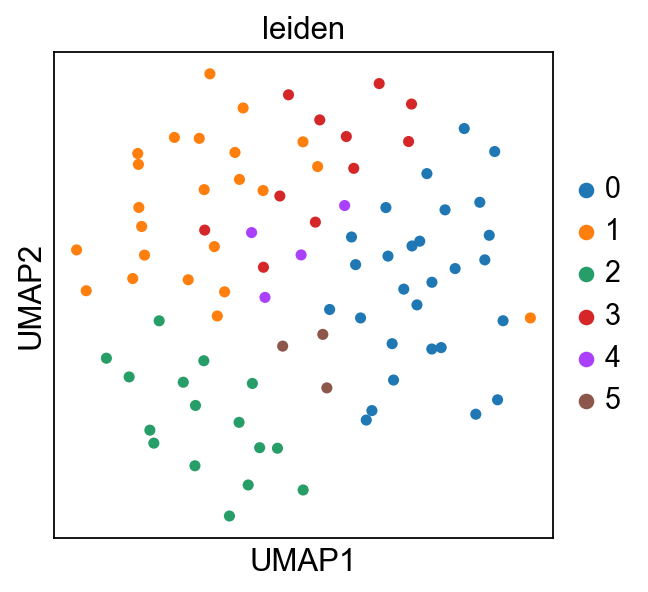

*Figure 7. Automatically identified clusters using the Leiden algorithm. Each point represents an RNA-seq sample. Samples with similar gene expression profiles are closer in the two-dimensional space. Sample groups are indicated using different colors, allowing for easier interpretation of the results.*

In [86]:
sc.pp.neighbors(adata, n_neighbors=10)
sc.tl.leiden(adata, resolution=1.0)
sc.tl.umap(adata)
default_node_size = 120000 / len(adata.obs.index)
node_size = min(100, 120000 / len(adata.obs.index))
sc.pl.umap(adata, color=['leiden'], size=node_size, save=True, show=True)
figure_counter = display_object(figure_counter, "Automatically identified clusters using the Leiden algorithm. Each point represents an RNA-seq sample. Samples with similar gene expression profiles are closer in the two-dimensional space. Sample groups are indicated using different colors, allowing for easier interpretation of the results.", istable=False)
display(create_download_link(adata.obs["leiden"], filename="clustering.csv"))
display_link("umap.pdf", "Download figure")

In [87]:
%%appyter markdown
{%if deg.value == True %}
# Differential Gene Expression
Gene expression signatures are alterations in the patterns of gene expression that occur as a result of cellular perturbations such as drug treatments, gene knock-downs or diseases. They can be quantified using differential gene expression (DGE) methods (Ritchie, Matthew E., et al. 2015, Clark, Neil R., et al. 2014), which compare gene expression between two groups of samples to identify genes whose expression is significantly altered in the perturbation.
{% endif %}


# Differential Gene Expression
Gene expression signatures are alterations in the patterns of gene expression that occur as a result of cellular perturbations such as drug treatments, gene knock-downs or diseases. They can be quantified using differential gene expression (DGE) methods (Ritchie, Matthew E., et al. 2015, Clark, Neil R., et al. 2014), which compare gene expression between two groups of samples to identify genes whose expression is significantly altered in the perturbation.


In [88]:
%%appyter code_exec
{% if deg.value == True %}

{% if enrichment_groupby.value == "user_defined_class" %}
classes = adata.obs[meta_class_column_name].unique().tolist()
cluster=False
if len(classes) < 2:
    print("Warning: Please provide at least 2 classes in the metadata")
{% else %}
meta_class_column_name = "leiden"
classes = sorted(adata.obs["leiden"].unique().tolist())
cluster=True
{% endif %}

if len(classes) > 10 or adata.n_obs > 5000:
    raise Exception('There are too many cells/clusters. It cannot execute the analysis code. Please run it locally.')
    
signatures = get_signatures(classes, adata, method=diff_gex_method, meta_class_column_name=meta_class_column_name, cluster=cluster)

if len(classes) > 1:
    for label, signature in signatures.items():
        table_counter = display_object(table_counter, "Differentially expressed genes between {} using {}. Every row of the table represents a gene; the columns display the estimated measures of differential expression.".format(label, diff_gex_method), signature, istable=True)
        display(create_download_link(signature, filename="DEG_{}.csv".format(label)))

{% endif %}

```python
meta_class_column_name = "leiden"
classes = sorted(adata.obs["leiden"].unique().tolist())
cluster=True
if len(classes) > 10 or adata.n_obs > 5000:
    raise Exception('There are too many cells/clusters. It cannot execute the analysis code. Please run it locally.')
signatures = get_signatures(classes, adata, method=diff_gex_method, meta_class_column_name=meta_class_column_name, cluster=cluster)
if len(classes) > 1:
    for label, signature in signatures.items():
        table_counter = display_object(table_counter, "Differentially expressed genes between {} using {}. Every row of the table represents a gene; the columns display the estimated measures of differential expression.".format(label, diff_gex_method), signature, istable=True)
        display(create_download_link(signature, filename="DEG_{}.csv".format(label)))
```

1 67.9
2 68.0
3 67.6
1 67.6
2 67.7
3 67.5
1 67.5
2 67.5
3 67.4
1 67.4
2 67.4
3 67.4
1 67.4
2 67.4
3 67.5
1 67.5
2 67.5
3 68.0


,logFC,AveExpr,t,P.Value,adj.P.Val,B
ZSCAN2,3.623122,0.271456,7.391392,7.768159e-11,5.474688e-07,14.057989
IGKV1OR2-108,2.213895,-0.917420,6.591894,3.042679e-09,1.340224e-05,10.865960
AC233755.1,5.482121,1.014300,6.432249,6.240368e-09,2.237249e-05,9.862679
IGKV1-17,3.156473,-0.514876,6.407304,6.978088e-09,2.237249e-05,10.096647
IGKV1-33,9.779861,4.018130,6.407119,6.983863e-09,2.237249e-05,9.404779
...,...,...,...,...,...,...
ITGB7,-7.209983,6.311552,-6.697868,1.883244e-09,1.048527e-05,10.456006
IGKV2D-30,-4.644689,1.715978,-7.543848,3.818501e-11,3.363909e-07,14.222578
CCND2,-7.552032,7.289302,-7.891952,7.473628e-12,8.778523e-08,15.119566
IGKJ5,-7.285917,4.424566,-8.419996,6.177255e-13,1.088371e-08,17.345016


*Table 5. Differentially expressed genes between Cluster 0 vs. rest using limma. Every row of the table represents a gene; the columns display the estimated measures of differential expression.*

,logFC,AveExpr,t,P.Value,adj.P.Val,B
ANG,4.288664,0.154484,6.664031,2.206407e-09,0.000039,10.353017
PERP,4.370340,0.845643,6.148705,2.211758e-08,0.000195,8.070080
NDRG1,4.702810,1.871536,6.074239,3.069907e-08,0.000216,7.487455
TRPV3,4.130281,2.226453,5.872436,7.408813e-08,0.000382,6.707442
IGKV2OR22-4,2.238831,-0.137827,5.733099,1.352078e-07,0.000596,6.950242
...,...,...,...,...,...,...
IGHG2,-4.966747,2.132473,-4.852787,5.203061e-06,0.013096,3.316046
IGHGP,-4.268382,1.900652,-4.889839,4.488434e-06,0.012166,3.464639
IGHG4,-5.470010,5.330480,-5.866785,7.592654e-08,0.000382,6.415873
TMSB4X,-5.774305,4.106658,-6.526575,4.103888e-09,0.000048,8.731574


*Table 6. Differentially expressed genes between Cluster 1 vs. rest using limma. Every row of the table represents a gene; the columns display the estimated measures of differential expression.*

,logFC,AveExpr,t,P.Value,adj.P.Val,B
CTSB,6.070189,5.110268,7.817396,1.059770e-11,2.834060e-07,15.421567
C1QB,5.084473,-0.263017,7.728459,1.608525e-11,2.834060e-07,15.754912
UCK2,5.076283,0.487924,7.604704,2.870881e-11,3.273064e-07,15.009773
AZGP1,6.724561,1.672500,7.549504,3.715379e-11,3.273064e-07,14.550502
ADAM23,3.981096,-0.414174,7.440460,6.177028e-11,4.353322e-07,14.530465
...,...,...,...,...,...,...
IGHGP,-5.201866,1.900652,-5.220240,1.170189e-06,9.589561e-04,5.183442
RGS1,-6.504731,4.697786,-5.276335,9.278845e-07,8.174198e-04,5.333120
FOSB,-5.926478,3.785883,-5.451180,4.469835e-07,4.922126e-04,5.995637
IGHG3,-6.758785,4.478393,-5.990948,4.404223e-08,7.390286e-05,8.049312


*Table 7. Differentially expressed genes between Cluster 2 vs. rest using limma. Every row of the table represents a gene; the columns display the estimated measures of differential expression.*

,logFC,AveExpr,t,P.Value,adj.P.Val,B
CEACAM22P,3.706624,-0.435675,8.186301,1.878328e-12,6.618853e-08,16.735898
RP1-34L19.1,2.745258,-0.616527,8.023539,4.047314e-12,7.130962e-08,16.409012
IGHV1OR15-3,5.079743,-0.812487,7.391789,7.791637e-11,9.152056e-07,13.957635
PCED1A,4.375906,-0.889985,7.121206,2.726146e-10,2.280421e-06,12.879174
POLR3G,5.095249,-0.891647,7.084003,3.235742e-10,2.280421e-06,12.723849
...,...,...,...,...,...,...
SNRPE,-3.694778,2.435150,-3.392367,1.038417e-03,9.352862e-02,-1.339512
TPI1,-4.179949,6.544062,-3.658438,4.309025e-04,6.544888e-02,-0.956461
RAB6A,-4.380518,2.950082,-3.759379,3.053115e-04,5.222605e-02,-0.589675
SNRPG,-4.120596,3.709070,-3.761942,3.026286e-04,5.221615e-02,-0.645076


*Table 8. Differentially expressed genes between Cluster 3 vs. rest using limma. Every row of the table represents a gene; the columns display the estimated measures of differential expression.*

,logFC,AveExpr,t,P.Value,adj.P.Val,B
IGHV3-33,12.502811,-0.365883,17.398576,2.532272e-30,8.923222e-26,39.818315
CH17-60O17.7,13.451770,-0.225633,15.949278,8.887509e-28,1.565890e-23,35.601928
IGHV3-30,12.890222,-0.300995,15.379409,9.579657e-27,1.125227e-22,34.881725
IGHV3-11,3.208657,-1.649861,14.614294,2.487407e-25,2.191281e-21,45.910929
IGHV3-6,3.052815,-1.656251,10.094721,2.139210e-16,1.507630e-12,26.591406
...,...,...,...,...,...,...
ZNF101,-3.720338,2.611439,-3.241245,1.677465e-03,4.216136e-01,-1.859634
RPP14,-4.343094,2.913145,-3.460838,8.305992e-04,2.523160e-01,-1.463180
SBF2,-4.329605,2.492083,-3.488235,7.592865e-04,2.346994e-01,-1.371094
ARIH1,-4.896803,5.815850,-3.531592,6.581216e-04,2.112392e-01,-1.438070


*Table 9. Differentially expressed genes between Cluster 4 vs. rest using limma. Every row of the table represents a gene; the columns display the estimated measures of differential expression.*

,logFC,AveExpr,t,P.Value,adj.P.Val,B
THAP3,5.074868,-1.208020,9.838927,7.188564e-16,2.533106e-11,24.644988
ARL6,6.792733,-1.356554,9.551350,2.819752e-15,4.968121e-11,23.771949
IGSF10,6.162271,-1.506150,9.413712,5.426879e-15,6.374412e-11,23.276704
RP11-506B6.7,3.816528,-1.262412,8.890944,6.528302e-14,5.751107e-10,20.772137
C7ORF25,4.435987,-1.548064,8.747361,1.292036e-13,9.105753e-10,20.340819
...,...,...,...,...,...,...
KCNK6,-3.001523,4.365618,-2.523412,1.340519e-02,8.366148e-01,-3.075696
ST6GAL1,-5.802800,6.094825,-2.523541,1.340060e-02,8.366148e-01,-3.088838
MRPL20,-4.673126,2.830580,-2.541087,1.279059e-02,8.366148e-01,-3.020722
KATNBL1,-4.355025,2.997775,-2.736972,7.492251e-03,6.929447e-01,-2.696949


*Table 10. Differentially expressed genes between Cluster 5 vs. rest using limma. Every row of the table represents a gene; the columns display the estimated measures of differential expression.*

In [89]:
%%appyter markdown
{%if deg.value == True %}
# Enrichment Analysis
Enrichment analysis is a bioinformatics method used to identify prior knowledge terms which are over-represented in a given gene set by comparing the gene set to many annotated gene sets. The prior-knowledge gene sets can represent cell signaling pathways, molecular functions, diseases, and a wide variety of other terms obtained by processing data from multiple resources. Enrichr (Kuleshov, M.V., et al. 2016) is a web-based application that  performs enrichment analysis against a large collection of gene-set libraries. It provides various interactive visualizations to display enrichment results.
{% endif %}


# Enrichment Analysis
Enrichment analysis is a bioinformatics method used to identify prior knowledge terms which are over-represented in a given gene set by comparing the gene set to many annotated gene sets. The prior-knowledge gene sets can represent cell signaling pathways, molecular functions, diseases, and a wide variety of other terms obtained by processing data from multiple resources. Enrichr (Kuleshov, M.V., et al. 2016) is a web-based application that  performs enrichment analysis against a large collection of gene-set libraries. It provides various interactive visualizations to display enrichment results.


```python
if diff_gex_method == "characteristic_direction":
    fc_colname = "CD-coefficient"
    sort_genes_by = "CD-coefficient"
    ascending = False
elif diff_gex_method == "limma":
    fc_colname = "logFC"
    sort_genes_by = "t"
    ascending = False
elif diff_gex_method == "edgeR":
    fc_colname = "logFC"
    sort_genes_by = "PValue"
    ascending = True
elif diff_gex_method == "DESeq2":
    fc_colname = "log2FoldChange"
    sort_genes_by = "padj"
    ascending = True
results['enrichr'] = {}
default_node_size = 120000 / len(adata.obs.index)
node_size = min(100, 120000 / len(adata.obs.index))
sc.pl.umap(adata, color=['leiden'], size=node_size)
for label, signature in signatures.items():
    # Run analysis
    case_name = label.split(" vs. ")[0]
    results['enrichr'][label] = run_enrichr(signature=signature, signature_label=label, fc_colname=fc_colname,geneset_size=gene_topk, sort_genes_by = sort_genes_by,ascending=ascending)
    display(Markdown("*Enrichment Analysis Result: {} (Up-regulated in {})*".format(label, case_name)))
    display_link("https://amp.pharm.mssm.edu/Enrichr/enrich?dataset={}".format(results['enrichr'][label]["upregulated"]["shortId"]))
    display(Markdown("*Enrichment Analysis Result: {} (Down-regulated in {})*".format(label, case_name)))
    display_link("https://amp.pharm.mssm.edu/Enrichr/enrich?dataset={}".format(results['enrichr'][label]["downregulated"]["shortId"]))
table_counter = display_object(table_counter, "The table displays links to Enrichr containing the results of enrichment analyses generated by analyzing the up-regulated and down-regulated genes from a differential expression analysis. By clicking on these links, users can interactively explore and download the enrichment results from the Enrichr website.", istable=True)
```

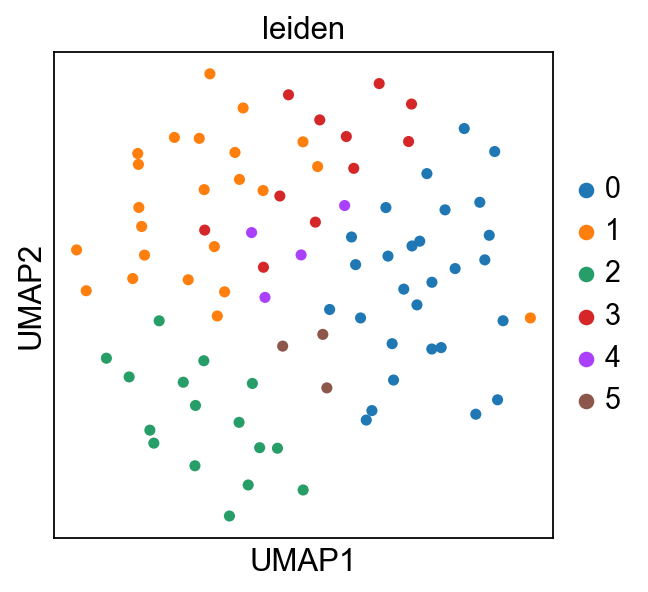

*Enrichment Analysis Result: Cluster 0 vs. rest (Up-regulated in Cluster 0)*

*Enrichment Analysis Result: Cluster 0 vs. rest (Down-regulated in Cluster 0)*

*Enrichment Analysis Result: Cluster 1 vs. rest (Up-regulated in Cluster 1)*

*Enrichment Analysis Result: Cluster 1 vs. rest (Down-regulated in Cluster 1)*

*Enrichment Analysis Result: Cluster 2 vs. rest (Up-regulated in Cluster 2)*

*Enrichment Analysis Result: Cluster 2 vs. rest (Down-regulated in Cluster 2)*

*Enrichment Analysis Result: Cluster 3 vs. rest (Up-regulated in Cluster 3)*

*Enrichment Analysis Result: Cluster 3 vs. rest (Down-regulated in Cluster 3)*

*Enrichment Analysis Result: Cluster 4 vs. rest (Up-regulated in Cluster 4)*

*Enrichment Analysis Result: Cluster 4 vs. rest (Down-regulated in Cluster 4)*

*Enrichment Analysis Result: Cluster 5 vs. rest (Up-regulated in Cluster 5)*

*Enrichment Analysis Result: Cluster 5 vs. rest (Down-regulated in Cluster 5)*

*Table 11. The table displays links to Enrichr containing the results of enrichment analyses generated by analyzing the up-regulated and down-regulated genes from a differential expression analysis. By clicking on these links, users can interactively explore and download the enrichment results from the Enrichr website.*

In [90]:
%%appyter code_exec
{%if deg.value == True %}
if diff_gex_method == "characteristic_direction":
    fc_colname = "CD-coefficient"
    sort_genes_by = "CD-coefficient"
    ascending = False
elif diff_gex_method == "limma":
    fc_colname = "logFC"
    sort_genes_by = "t"
    ascending = False
elif diff_gex_method == "edgeR":
    fc_colname = "logFC"
    sort_genes_by = "PValue"
    ascending = True
elif diff_gex_method == "DESeq2":
    fc_colname = "log2FoldChange"
    sort_genes_by = "padj"
    ascending = True
    
results['enrichr'] = {}
{% if enrichment_groupby.value != "user_defined_class" %}
default_node_size = 120000 / len(adata.obs.index)
node_size = min(100, 120000 / len(adata.obs.index))
sc.pl.umap(adata, color=['leiden'], size=node_size)
{% endif %}
for label, signature in signatures.items():
    # Run analysis
    {% if enrichment_groupby.value == "user_defined_class" %}
    case_name = label.split(" vs. ")[1]
    {% else %}
    case_name = label.split(" vs. ")[0]
    {% endif %}
    results['enrichr'][label] = run_enrichr(signature=signature, signature_label=label, fc_colname=fc_colname,geneset_size=gene_topk, sort_genes_by = sort_genes_by,ascending=ascending)
    display(Markdown("*Enrichment Analysis Result: {} (Up-regulated in {})*".format(label, case_name)))
    display_link("https://amp.pharm.mssm.edu/Enrichr/enrich?dataset={}".format(results['enrichr'][label]["upregulated"]["shortId"]))
    display(Markdown("*Enrichment Analysis Result: {} (Down-regulated in {})*".format(label, case_name)))
    display_link("https://amp.pharm.mssm.edu/Enrichr/enrich?dataset={}".format(results['enrichr'][label]["downregulated"]["shortId"]))
table_counter = display_object(table_counter, "The table displays links to Enrichr containing the results of enrichment analyses generated by analyzing the up-regulated and down-regulated genes from a differential expression analysis. By clicking on these links, users can interactively explore and download the enrichment results from the Enrichr website.", istable=True)
{% endif %}

In [91]:
%%appyter markdown
{% if deg.value == True and "Gene Ontology" in enrichr_libraries.value %}
# Gene Ontology Enrichment Analysis
Gene Ontology (GO) (Ashburner, M., et al. 2000) is a major initiative aimed at unifying the representation of gene attributes across all species. It contains a large collection of experimentally validated and predicted associations between genes and biological terms. This information can be leveraged by Enrichr to identify enriched biological processes, molecular functions and cellular components which are over-represented in the up-regulated genes from each cluster.
{% endif %}


# Gene Ontology Enrichment Analysis
Gene Ontology (GO) (Ashburner, M., et al. 2000) is a major initiative aimed at unifying the representation of gene attributes across all species. It contains a large collection of experimentally validated and predicted associations between genes and biological terms. This information can be leveraged by Enrichr to identify enriched biological processes, molecular functions and cellular components which are over-represented in the up-regulated genes from each cluster.


In [92]:
%%appyter code_exec
{% if deg.value == True and "Gene Ontology" in enrichr_libraries.value %}

results['go_enrichment'] = {}
for label, signature in signatures.items():
    # Run analysis
    results['go_enrichment'][label] = get_enrichr_results_by_library(results['enrichr'][label], label, library_type='go', version='2018')
    
for label, signature in signatures.items():
    {% if enrichment_groupby.value == "user_defined_class" %}
    case_name = label.split(" vs. ")[1]
    {% else %}
    case_name = label.split(" vs. ")[0]
    {% endif %}
    
    # Create dataframe
    enrichment_results = results['go_enrichment'][label]
    enrichment_dataframe = pd.concat([enrichment_results['upregulated'], enrichment_results['downregulated']])

    # Plot barcharts
    libraries = enrichment_dataframe['gene_set_library'].unique()   
    for gene_set_library in libraries:
        plot_library_barchart(enrichment_results, gene_set_library, enrichment_results['signature_label'], case_name, enrichment_results['sort_results_by'], nr_genesets=nr_genesets, plot_type=plot_type) # 10 300
    figure_counter = display_object(figure_counter, "Enrichment Analysis Results for {} in Gene Onotology. The figure contains interactive bar charts displaying the results of the Gene Ontology enrichment analysis generated using Enrichr. The x axis indicates the -log10(P-value) for each term. Significant terms are highlighted in bold. Additional information about enrichment results is available by hovering over each bar.".format(label), istable=False)
{% endif %}

```python
results['go_enrichment'] = {}
for label, signature in signatures.items():
    # Run analysis
    results['go_enrichment'][label] = get_enrichr_results_by_library(results['enrichr'][label], label, library_type='go', version='2018')
for label, signature in signatures.items():
    case_name = label.split(" vs. ")[0]
    # Create dataframe
    enrichment_results = results['go_enrichment'][label]
    enrichment_dataframe = pd.concat([enrichment_results['upregulated'], enrichment_results['downregulated']])
    # Plot barcharts
    libraries = enrichment_dataframe['gene_set_library'].unique()
    for gene_set_library in libraries:
        plot_library_barchart(enrichment_results, gene_set_library, enrichment_results['signature_label'], case_name, enrichment_results['sort_results_by'], nr_genesets=nr_genesets, plot_type=plot_type) # 10 300
    figure_counter = display_object(figure_counter, "Enrichment Analysis Results for {} in Gene Onotology. The figure contains interactive bar charts displaying the results of the Gene Ontology enrichment analysis generated using Enrichr. The x axis indicates the -log10(P-value) for each term. Significant terms are highlighted in bold. Additional information about enrichment results is available by hovering over each bar.".format(label), istable=False)
```

*Figure 8. Enrichment Analysis Results for Cluster 0 vs. rest in Gene Onotology. The figure contains interactive bar charts displaying the results of the Gene Ontology enrichment analysis generated using Enrichr. The x axis indicates the -log10(P-value) for each term. Significant terms are highlighted in bold. Additional information about enrichment results is available by hovering over each bar.*

*Figure 9. Enrichment Analysis Results for Cluster 1 vs. rest in Gene Onotology. The figure contains interactive bar charts displaying the results of the Gene Ontology enrichment analysis generated using Enrichr. The x axis indicates the -log10(P-value) for each term. Significant terms are highlighted in bold. Additional information about enrichment results is available by hovering over each bar.*

*Figure 10. Enrichment Analysis Results for Cluster 2 vs. rest in Gene Onotology. The figure contains interactive bar charts displaying the results of the Gene Ontology enrichment analysis generated using Enrichr. The x axis indicates the -log10(P-value) for each term. Significant terms are highlighted in bold. Additional information about enrichment results is available by hovering over each bar.*

*Figure 11. Enrichment Analysis Results for Cluster 3 vs. rest in Gene Onotology. The figure contains interactive bar charts displaying the results of the Gene Ontology enrichment analysis generated using Enrichr. The x axis indicates the -log10(P-value) for each term. Significant terms are highlighted in bold. Additional information about enrichment results is available by hovering over each bar.*

*Figure 12. Enrichment Analysis Results for Cluster 4 vs. rest in Gene Onotology. The figure contains interactive bar charts displaying the results of the Gene Ontology enrichment analysis generated using Enrichr. The x axis indicates the -log10(P-value) for each term. Significant terms are highlighted in bold. Additional information about enrichment results is available by hovering over each bar.*

*Figure 13. Enrichment Analysis Results for Cluster 5 vs. rest in Gene Onotology. The figure contains interactive bar charts displaying the results of the Gene Ontology enrichment analysis generated using Enrichr. The x axis indicates the -log10(P-value) for each term. Significant terms are highlighted in bold. Additional information about enrichment results is available by hovering over each bar.*

In [93]:
%%appyter markdown
{% if deg.value == True and "Pathway" in enrichr_libraries.value %}
# Pathway Enrichment Analysis
Biological pathways are sequences of interactions between biochemical compounds which play a key role in determining cellular behavior. Databases such as KEGG (Kanehisa et al. 2000), Reactome (Croft et al. 2014) and WikiPathways (Kelder et al. 2012) contain a large number of associations between such pathways and genes. This information can be leveraged by Enrichr to identify the biological pathways which are over-represented in the up-regulated and down-regulated genes identified by comparing two groups of samples.
{% endif %}

In [94]:
%%appyter code_exec
{% if deg.value == True and "Pathway" in enrichr_libraries.value %}
# Initialize results
results['pathway_enrichment'] = {}

# Loop through results
for label, signature in signatures.items():
    # Run analysis
    results['pathway_enrichment'][label] = get_enrichr_results_by_library(results['enrichr'][label], label, library_type='pathway')

for label, signature in signatures.items():
    {% if enrichment_groupby.value == "user_defined_class" %}
    case_name = label.split(" vs. ")[1]
    {% else %}
    case_name = label.split(" vs. ")[0]
    {% endif %}
    
    # Create dataframe
    enrichment_results = results['pathway_enrichment'][label]
    enrichment_dataframe = pd.concat([enrichment_results['upregulated'], enrichment_results['downregulated']])

    # Plot barcharts
    libraries = enrichment_dataframe['gene_set_library'].unique()   
    for gene_set_library in libraries:
        # Display results
        plot_library_barchart(enrichment_results, gene_set_library, enrichment_results['signature_label'], case_name, enrichment_results['sort_results_by'], nr_genesets=nr_genesets, plot_type=plot_type)
    figure_counter = display_object(figure_counter, "Enrichment Analysis Results for {} in KEGG Pathways, WikiPathways and Reactome Pathways. The figure contains interactive bar charts displaying the results of the Gene Ontology enrichment analysis generated using Enrichr. The x axis indicates the -log10(P-value) for each term. Significant terms are highlighted in bold. Additional information about enrichment results is available by hovering over each bar.".format(label), istable=False)
{% endif %}

In [95]:
%%appyter markdown
{% if deg.value == True and "Transcription Factor" in enrichr_libraries.value %}
# Transcription Factor Enrichment Analysis
Transcription Factors (TFs) are proteins involved in the transcriptional regulation of gene expression. Databases such as ChEA (Lachmann et al. 2010) and ENCODE (Consortium, 2014) contain a large number of associations between TFs and their transcriptional targets. This information can be leveraged by Enrichr to identify the transcription factors whose targets are over-represented in the up-regulated and down-regulated genes identified by comparing two groups of samples.
{% endif %}

In [96]:
%%appyter code_exec
{% if deg.value == True and "Transcription Factor" in enrichr_libraries.value %}
# Initialize results
results['tf_enrichment'] = {}
# Loop through results
for label, signature in signatures.items():
    # Run analysis
    results['tf_enrichment'][label] = get_enrichr_result_tables_by_library(enrichr_results=results['enrichr'][label], signature_label=label, library_type='tf')
    table_counter = display_table(results['tf_enrichment'][label], "Transcription Factor", table_counter)
{% endif %} 


In [97]:
%%appyter markdown
{% if deg.value == True and "Kinase" in enrichr_libraries.value %}
# Kinase Enrichment Analysis
Protein kinases are enzymes that modify other proteins by chemically adding phosphate groups. Databases such as KEA (Lachmann et al. 2009) contain a large number of associations between kinases and their substrates. This information can be leveraged by Enrichr to identify the protein kinases whose substrates are over-represented in the up-regulated and down-regulated genes identified by comparing two groups of samples.
{% endif %}

In [98]:
%%appyter code_exec
{% if deg.value == True and "Kinase" in enrichr_libraries.value %}
# Initialize results
results['kinase_enrichment'] = {}

# Loop through results
for label, enrichr_results in results['enrichr'].items():
    # Run analysis
    results['kinase_enrichment'][label] = get_enrichr_result_tables_by_library(enrichr_results=enrichr_results, signature_label=label, library_type="ke")

    # Display results
    table_counter = display_table(results['kinase_enrichment'][label], "Kinase", table_counter)
{% endif %}

In [99]:
%%appyter markdown
{% if deg.value == True and "miRNA" in enrichr_libraries.value %}
# miRNA Enrichment Analysis
microRNAs (miRNAs) are small non-coding RNA molecules which play a key role in the post-transcriptional regulation of gene expression. Databases such as TargetScan (Agarwal et al. 2015) and MiRTarBase (Chou et al. 2016) contain a large number of associations between miRNAs and their targets. This information can be leveraged by Enrichr to identify the miRNAs whose targets are over-represented in the up-regulated and down-regulated genes identified by comparing two groups of samples.
{% endif %}

In [100]:
%%appyter code_exec
{% if deg.value == True and "miRNA" in enrichr_libraries.value %}

results['mirna_enrichment'] = {}

# Loop through results
for label, enrichr_results in results['enrichr'].items():
    # Run analysis
    results['mirna_enrichment'][label] = get_enrichr_result_tables_by_library(enrichr_results=enrichr_results, signature_label=label, library_type="mirna")

    # Display results
    table_counter = display_table(results['mirna_enrichment'][label], "miRNA", table_counter)
{% endif %}

In [101]:
%%appyter markdown
{% if deg.value == True and "Cell Type" in enrichr_libraries.value %}
# Cell Type Enrichment Analysis
{% endif %}


# Cell Type Enrichment Analysis


In [110]:
%%appyter code_exec
{% if deg.value == True and "Cell Type" in enrichr_libraries.value %}

results['celltype_enrichment'] = {}
for label, signature in signatures.items():
    # Run analysis
    results['celltype_enrichment'][label] = get_enrichr_results_by_library(results['enrichr'][label], label, library_type='celltype')
    
for label, signature in signatures.items():
    {% if enrichment_groupby.value == "user_defined_class" %}
    case_name = label.split(" vs. ")[1]
    {% else %}
    case_name = label.split(" vs. ")[0]
    {% endif %}
    
    # Create dataframe
    enrichment_results = results['celltype_enrichment'][label]
    enrichment_dataframe = pd.concat([enrichment_results['upregulated'], enrichment_results['downregulated']])

    # Plot barcharts
    libraries = enrichment_dataframe['gene_set_library'].unique()   
    for gene_set_library in libraries:
        plot_library_barchart(enrichment_results, gene_set_library, enrichment_results['signature_label'], case_name, enrichment_results['sort_results_by'], nr_genesets=nr_genesets, plot_type=plot_type) # 10 300
    figure_counter = display_object(figure_counter, "Enrichment Analysis Results for {} in Cell Type. The figure contains interactive bar charts displaying the results of the Gene Ontology enrichment analysis generated using Enrichr. The x axis indicates the -log10(P-value) for each term. Significant terms are highlighted in bold. Additional information about enrichment results is available by hovering over each bar.".format(label), istable=False)
{% endif %}

```python
results['celltype_enrichment'] = {}
for label, signature in signatures.items():
    # Run analysis
    results['celltype_enrichment'][label] = get_enrichr_results_by_library(results['enrichr'][label], label, library_type='celltype')
for label, signature in signatures.items():
    case_name = label.split(" vs. ")[0]
    # Create dataframe
    enrichment_results = results['celltype_enrichment'][label]
    enrichment_dataframe = pd.concat([enrichment_results['upregulated'], enrichment_results['downregulated']])
    # Plot barcharts
    libraries = enrichment_dataframe['gene_set_library'].unique()
    for gene_set_library in libraries:
        plot_library_barchart(enrichment_results, gene_set_library, enrichment_results['signature_label'], case_name, enrichment_results['sort_results_by'], nr_genesets=nr_genesets, plot_type=plot_type) # 10 300
    figure_counter = display_object(figure_counter, "Enrichment Analysis Results for {} in Cell Type. The figure contains interactive bar charts displaying the results of the Gene Ontology enrichment analysis generated using Enrichr. The x axis indicates the -log10(P-value) for each term. Significant terms are highlighted in bold. Additional information about enrichment results is available by hovering over each bar.".format(label), istable=False)
```

*Figure 21. Enrichment Analysis Results for Cluster 0 vs. rest in Cell Type. The figure contains interactive bar charts displaying the results of the Gene Ontology enrichment analysis generated using Enrichr. The x axis indicates the -log10(P-value) for each term. Significant terms are highlighted in bold. Additional information about enrichment results is available by hovering over each bar.*

*Figure 22. Enrichment Analysis Results for Cluster 1 vs. rest in Cell Type. The figure contains interactive bar charts displaying the results of the Gene Ontology enrichment analysis generated using Enrichr. The x axis indicates the -log10(P-value) for each term. Significant terms are highlighted in bold. Additional information about enrichment results is available by hovering over each bar.*

*Figure 23. Enrichment Analysis Results for Cluster 2 vs. rest in Cell Type. The figure contains interactive bar charts displaying the results of the Gene Ontology enrichment analysis generated using Enrichr. The x axis indicates the -log10(P-value) for each term. Significant terms are highlighted in bold. Additional information about enrichment results is available by hovering over each bar.*

*Figure 24. Enrichment Analysis Results for Cluster 3 vs. rest in Cell Type. The figure contains interactive bar charts displaying the results of the Gene Ontology enrichment analysis generated using Enrichr. The x axis indicates the -log10(P-value) for each term. Significant terms are highlighted in bold. Additional information about enrichment results is available by hovering over each bar.*

*Figure 25. Enrichment Analysis Results for Cluster 4 vs. rest in Cell Type. The figure contains interactive bar charts displaying the results of the Gene Ontology enrichment analysis generated using Enrichr. The x axis indicates the -log10(P-value) for each term. Significant terms are highlighted in bold. Additional information about enrichment results is available by hovering over each bar.*

*Figure 26. Enrichment Analysis Results for Cluster 5 vs. rest in Cell Type. The figure contains interactive bar charts displaying the results of the Gene Ontology enrichment analysis generated using Enrichr. The x axis indicates the -log10(P-value) for each term. Significant terms are highlighted in bold. Additional information about enrichment results is available by hovering over each bar.*

In [103]:
%%appyter markdown
{% if trajectory.value == True %}
# Trajectory Inference
Trajectory inference is a computational technique used in single-cell transcriptomics to arrange cells based on their progression through the differentiation process. It orders single cells in pseudotime, placing them along a trajectory corresponding to a biological process such as cell differentiation by taking advantage of single cells’ asynchronous progression through those processes. Diffusion pseudotime (DPT) (Haghverdi, Laleh, et al. 2016), which measures transitions between cells using diffusion-like random walks is one of the methods used to identify such trajectories. Monocle (Trapnell, Cole, et al. 2014) is a method for ordering cells by learning an explicit principal graph from the single cell expression data with advanced machine learning techniques (Reversed Graph Embedding), which robustly and accurately resolves complicated biological processes.
{% endif %}


# Trajectory Inference
Trajectory inference is a computational technique used in single-cell transcriptomics to arrange cells based on their progression through the differentiation process. It orders single cells in pseudotime, placing them along a trajectory corresponding to a biological process such as cell differentiation by taking advantage of single cells’ asynchronous progression through those processes. Diffusion pseudotime (DPT) (Haghverdi, Laleh, et al. 2016), which measures transitions between cells using diffusion-like random walks is one of the methods used to identify such trajectories. Monocle (Trapnell, Cole, et al. 2014) is a method for ordering cells by learning an explicit principal graph from the single cell expression data with advanced machine learning techniques (Reversed Graph Embedding), which robustly and accurately resolves complicated biological processes.


In [115]:
adata.n_obs

85

```python
if trajectory_method == "monocle":
    # Run analysis
    results['monocle'] = run_monocle(dataset=adata, plot_type=plot_type, color_by='Pseudotime')
    # Display results
    plot_monocle(results['monocle'])
elif trajectory_method == "dpt":
    adata.uns['iroot'] = 0
    sc.tl.draw_graph(adata)
    sc.tl.dpt(adata)
    sc.pl.draw_graph(adata, color=[meta_class_column_name, 'dpt_pseudotime'], legend_loc='on data', save=True, show=True, size=30000 / adata.n_obs)
    display_link("draw_graph_fa.pdf", "Download figure")
figure_counter = display_object(figure_counter, "Trajectory inference result using {}. Each point represents an RNA-seq sample. Sample colors are based on pseudotime.".format(trajectory_method), istable=False)
```

drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:00)
computing Diffusion Pseudotime using n_dcs=10
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)


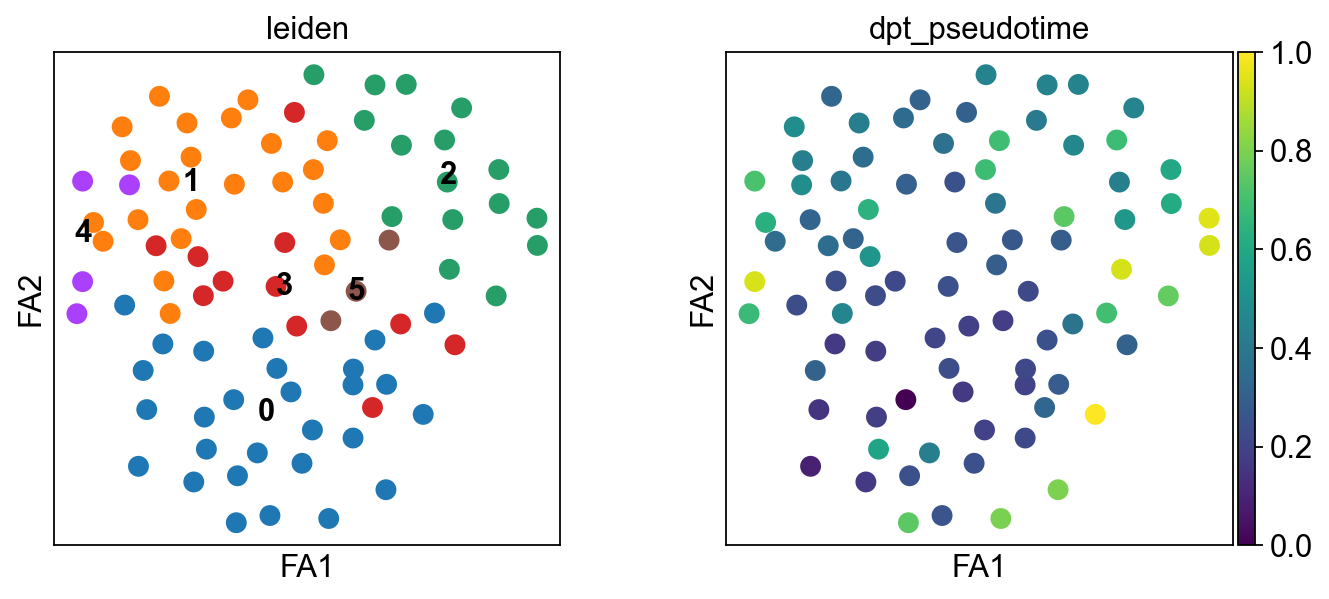

*Figure 34. Trajectory inference result using dpt. Each point represents an RNA-seq sample. Sample colors are based on pseudotime.*

In [120]:
%%appyter code_exec
{% if trajectory.value == True %}
if trajectory_method == "monocle":
    # Run analysis
    results['monocle'] = run_monocle(dataset=adata, plot_type=plot_type, color_by='Pseudotime')

    # Display results
    plot_monocle(results['monocle'])
    
elif trajectory_method == "dpt":
    adata.uns['iroot'] = 0
    sc.tl.draw_graph(adata)
    sc.tl.dpt(adata)
    sc.pl.draw_graph(adata, color=[meta_class_column_name, 'dpt_pseudotime'], legend_loc='on data', save=True, show=True, size=30000 / adata.n_obs)
    display_link("draw_graph_fa.pdf", "Download figure")
figure_counter = display_object(figure_counter, "Trajectory inference result using {}. Each point represents an RNA-seq sample. Sample colors are based on pseudotime.".format(trajectory_method), istable=False)
{% endif %}

In [105]:
%%appyter markdown
{% if time_series_trajectory.value == True %}
# Time-series Trajectory Analysis
When time-series data is available, it is possible to order cells by their progression through a dynamic
process using time information. Tempora (Tran, Thinh N., and Gary Bader 2016), a pathway-based cell trajectory inference method that orders cells using time information from the data, infers developmental linages based on biological pathway information. This time-series based analysis can generate insights into dynamic processes and their biological regulation. 
{% endif %}

In [106]:
%%appyter code_exec
{% if time_series_trajectory.value == True %}
run_tempora(adata, timepoint_labels_column_name, timepoint_labels)
display(Image.open("Tempora_plot.jpg"))
figure_counter = display_object(figure_counter, "Time-series trajectory inference result using Tempora. Tempora visualizes the result as a network, with the piechart at each node representing the composition of cells collected at different time points in the experiment and the arrow connecting each pair of nodes representing lineage relationship between them.", istable=False)
display(FileLink("Tempora_plot.jpg", result_html_prefix="Download figure"))
{% endif %}

In [107]:
%%appyter markdown
{% if cell_type_prediction.value == True %}
# Cell Type Prediction with DigitalCellSorter 
DigitalCellSorter (Domanskyi, Sergii, et al. 2019) is an unbiased cell type recognition algorithm for scRNA-seq. It leverages a manual assessment using a few selected markers of cell types and infers the cell of origin for each of the single cells independently.
{% endif %}

In [108]:
%%appyter code_exec
{% if cell_type_prediction.value == True %}
DCS = DigitalCellSorter.DigitalCellSorter(nComponentsPCA=3)
DCS.annotationMethod='pDCS'
DCS.makePlots = False
df_expr = adata.raw.to_adata().to_df().T
DCS.prepare(df_expr)
DCS.process()

ann= DCS.annotate()

# Run analysis
results['dimension_reduction'] = run_dimension_reduction(dim_reduction_method, dataset=adata, meta_class_column_name=meta_class_column_name, nr_genes=nr_genes, plot_type=plot_type)
ids = [x[1] for x in DCS.df_expr.columns]
clusters = [ann[x[2]] for x in DCS.df_expr.columns] 
new_cluster_df = pd.DataFrame([ids, clusters]).T.set_index(0)
new_cluster_df.columns = [meta_class_column_name]
results['dimension_reduction']['sample_metadata'] = new_cluster_df

# # Display results
plot_dimension_reduction(results['dimension_reduction'])
figure_counter = display_object(figure_counter, "Cell type prediction result using DigitalCellSorter. Each point represents an RNA-seq sample. Predicted sample cell types are indicated using different colors.", istable=False)

{% endif %}

# References 

Ashburner, M., Ball, C.A., Blake, J.A., Botstein, D., Butler, H., Cherry, J.M., Davis, A.P., Dolinski, K., Dwight, S.S. and Eppig, J.T. (2000) Gene Ontology: tool for the unification of biology. Nature genetics, 25, 25.
<br>
Butler, Andrew, et al. "Integrating single-cell transcriptomic data across different conditions, technologies, and species." Nature biotechnology 36.5 (2018): 411-420.
<br>
Clark, N.R. and Ma’ayan, A. (2011) Introduction to statistical methods to analyze large data sets: principal components analysis. Sci. Signal., 4, tr3-tr3.
<br>
Clark, Neil R., et al. "The characteristic direction: a geometrical approach to identify differentially expressed genes." BMC bioinformatics 15.1 (2014): 79.
<br>
Consortium, E.P. (2004) The ENCODE (ENCyclopedia of DNA elements) project. Science, 306, 636-640.
<br>
Croft, David, et al. "The Reactome pathway knowledgebase." Nucleic acids research 42.D1 (2014): D472-D477.
<br>
Domanskyi, Sergii, et al. "Polled Digital Cell Sorter (p-DCS): Automatic identification of hematological cell types from single cell RNA-sequencing clusters." BMC bioinformatics 20.1 (2019): 369.
<br>
Fernandez, Nicolas F., et al. "Clustergrammer, a web-based heatmap visualization and analysis tool for high-dimensional biological data." Scientific data 4 (2017): 170151.
<br>
Haghverdi, Laleh, et al. "Diffusion pseudotime robustly reconstructs lineage branching." Nature methods 13.10 (2016): 845.
<br>
Ilicic, Tomislav, et al. "Classification of low quality cells from single-cell RNA-seq data." Genome biology 17.1 (2016): 29.
<br>
Islam, Saiful, et al. "Quantitative single-cell RNA-seq with unique molecular identifiers." Nature methods 11.2 (2014): 163.
<br>
Kanehisa, M. and Goto, S. (2000) KEGG: kyoto encyclopedia of genes and genomes. Nucleic acids research, 28, 27-30.
<br>
Kuleshov, M.V., Jones, M.R., Rouillard, A.D., Fernandez, N.F., Duan, Q., Wang, Z., Koplev, S., Jenkins, S.L., Jagodnik, K.M. and Lachmann, A. (2016) Enrichr: a comprehensive gene set enrichment analysis web server 2016 update. Nucleic acids research, 44, W90-W97.
<br>
Lachmann, A., Xu, H., Krishnan, J., Berger, S.I., Mazloom, A.R. and Ma'ayan, A. (2010) ChEA: transcription factor regulation inferred from integrating genome-wide ChIP-X experiments. Bioinformatics, 26, 2438-2444.
<br>
Lachmann, Alexander, and Avi Ma'ayan. "KEA: kinase enrichment analysis." Bioinformatics 25.5 (2009): 684-686.
<br>
Maaten, Laurens van der, and Geoffrey Hinton. "Visualizing data using t-SNE." Journal of machine learning research 9.Nov (2008): 2579-2605.
<br>
McInnes, Leland, John Healy, and James Melville. "Umap: Uniform manifold approximation and projection for dimension reduction." arXiv preprint arXiv:1802.03426 (2018).
<br>
Ritchie, Matthew E., et al. "limma powers differential expression analyses for RNA-sequencing and microarray studies." Nucleic acids research 43.7 (2015): e47-e47.
<br>
Traag, Vincent A., Ludo Waltman, and Nees Jan van Eck. "From Louvain to Leiden: guaranteeing well-connected communities." Scientific reports 9.1 (2019): 1-12.
<br>
Tran, Thinh N., and Gary Bader. "Tempora: cell trajectory inference using time-series single-cell RNA sequencing data." bioRxiv (2019): 846907.
<br>
Trapnell, Cole, et al. "The dynamics and regulators of cell fate decisions are revealed by pseudotemporal ordering of single cells." Nature biotechnology 32.4 (2014): 381.
<br>
van Dijk, D., Nainys, J., Sharma, R., Kathail, P., Carr, A.J., Moon, K.R., Mazutis, L., Wolf, G., Krishnaswamy, S. and Pe'er, D. (2017) MAGIC: A diffusion-based imputation method reveals gene-gene interactions in single-cell RNA-sequencing data. BioRxiv, 111591.
<br>
Weinreb, Caleb, et al. "Fundamental limits on dynamic inference from single-cell snapshots." Proceedings of the National Academy of Sciences 115.10 (2018): E2467-E2476.
<br>
Zheng, Grace XY, et al. "Massively parallel digital transcriptional profiling of single cells." Nature communications 8.1 (2017): 1-12.